In [1]:
# !pip install --upgrade pip
# !pip install -r requirements_n.txt 

In [2]:
import os
import json
import h5py
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
#; sns.set_theme(color_codes=True)

RAW_DATA_DIR = "../input/raw_data" # 카카오에서 다운로드 받은 데이터의 디렉터리
PROCESSED_DATA_DIR = '../input/processed' # 전처리된 데이터가 저장될 디렉터리
VOCAB_DIR = os.path.join(PROCESSED_DATA_DIR, 'vocab') # 전처리에 사용될 사전 파일이 저장될 디렉터리

# 학습에 사용될 파일 리스트
train_file_list = [
    "train.chunk.01",
    "train.chunk.02",
    "train.chunk.03",
    "train.chunk.04",
    "train.chunk.05",
    "train.chunk.06",
    "train.chunk.07",
    "train.chunk.08",
    "train.chunk.09"
]

# 개발에 사용될 파일 리스트. 공개 리더보드 점수를 내는데 사용된다.
dev_file_list = [
    "dev.chunk.01"    
]

# 테스트에 사용될 파일 리스트. 파이널 리더보드 점수를 내는데 사용된다.
test_file_list = [
    "test.chunk.01",
    "test.chunk.02", 
]


In [3]:
# 파일명과 실제 파일이 위치한 디렉토리를 결합한다.
train_path_list = [os.path.join(RAW_DATA_DIR, fn) for fn in train_file_list]
dev_path_list = [os.path.join(RAW_DATA_DIR, fn) for fn in dev_file_list]
test_path_list = [os.path.join(RAW_DATA_DIR, fn) for fn in test_file_list]

In [4]:
# PROCESSED_DATA_DIR과 VOCAB_DIR를 생성한다.
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(VOCAB_DIR, exist_ok=True)

In [5]:
#대회 데이터를 pandas.DataFrame으로 만들기

In [6]:
# path_list의 파일에서 col 변수에 해당하는 컬럼 값들을 가져온다.
def get_column_data(path_list, div, col):
    col_data = []
    for path in path_list:
        h = h5py.File(path, 'r')
        col_data.append(h[div][col][:])
        h.close()
    return np.concatenate(col_data)

# path_list의 파일에서 학습에 필요한 컬럼들을 DataFrame 포맷으로 반환한다.
def get_dataframe(path_list, div):
    pids = get_column_data(path_list, div, col='pid')
    products = get_column_data(path_list, div, col='product')
    brands = get_column_data(path_list, div, col='brand')
    makers = get_column_data(path_list, div, col='maker')
    # 16GB를 가진 PC에서 실행 가능하도록 메모리를 많이 사용하는 칼럼은 주석처리
    #models = get_column_data(path_list, div, col='model') 
    prices = get_column_data(path_list, div, col='price')
    updttms = get_column_data(path_list, div, col='updttm')
    bcates = get_column_data(path_list, div, col='bcateid')
    mcates = get_column_data(path_list, div, col='mcateid')
    scates = get_column_data(path_list, div, col='scateid')
    dcates = get_column_data(path_list, div, col='dcateid')
    
    df = pd.DataFrame({'pid': pids, 'product':products, 'brand':brands, 'maker':makers, 
                                      #'model':models, 
                                      'price':prices, 'updttm':updttms, 
                                      'bcateid':bcates, 'mcateid':mcates, 'scateid':scates, 'dcateid':dcates} )
    
    # 바이트 열로 인코딩 상품제목과 상품ID를 유니코드 변환한다.
    df['pid'] = df['pid'].map(lambda x: x.decode('utf-8'))
    df['product'] = df['product'].map(lambda x: x.decode('utf-8'))
    df['brand'] = df['brand'].map(lambda x: x.decode('utf-8'))
    df['maker'] = df['maker'].map(lambda x: x.decode('utf-8'))
    #df['model'] = df['model'].map(lambda x: x.decode('utf-8')) # 메모리 사용량을 줄이기 위해 주석처리
    df['updttm'] = df['updttm'].map(lambda x: x.decode('utf-8'))     
    
    return df

In [7]:
#train_df = get_dataframe(train_path_list, 'train')
#dev_df = get_dataframe(dev_path_list, 'dev')
#test_df = get_dataframe(test_path_list, 'test')

#train_df.to_csv('train_df.csv')

train_df = pd.read_csv('train_df.csv')
del train_df['Unnamed: 0']

In [8]:
print("train_df.shape : ", train_df.shape)
#print("dev_df.shape : ", dev_df.shape)
#print("test_df.shape : ", test_df.shape)

train_df.shape :  (8134818, 10)


In [9]:
print("train_df.columns : ", train_df.columns)
print("# train_df.columns : ", len(list(train_df.columns)))

train_df.columns :  Index(['pid', 'product', 'brand', 'maker', 'price', 'updttm', 'bcateid',
       'mcateid', 'scateid', 'dcateid'],
      dtype='object')
# train_df.columns :  10


In [10]:
train_df.head(20)

,pid,product,brand,maker,price,updttm,bcateid,mcateid,scateid,dcateid
0,O4486751463,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),퍼즐라이프,상품상세설명 참조,16520,20180227091029,1,1,2,-1
1,P3307178849,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...,바보사랑,MORY|해당없음,20370,20180429085019,3,3,4,-1
2,R4424255515,크리비아 기모 3부 속바지 GLG4314P,크리비아,NaN,-1,20180426102314,5,5,6,-1
3,F3334315393,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,잭앤질,㈜크리스패션,16280,20180422084512,7,7,8,-1
4,N731678492,코드프리혈당시험지50매/코드프리시험지/최장유효기간,NaN,기타,-1,20180424071623,10,9,11,-1
5,J4094617432,아트박스 POOM/낭만창고 idk385-시원한 맥주 캬하~,NaN,NaN,-1,20180426150317,11,10,12,-1
6,V4742097320,데버스 뉴 캠핑 BBQ 글러브 DVC E1209N 캠핑 등산,NaN,기타,-1,20180422222810,12,11,13,-1
7,Z4154445264,엘르스포츠 여성 비키니2PCS ETFLB06NVY,엘르스포츠,기타,-1,20180420064936,13,12,14,-1
8,L2121928457,[패션플러스][GEOX][GEOX] 제옥스 GH-405 블랙펄 클러치백,제옥스,제옥스,30750,20180419090423,14,13,15,-1
9,J2944368118,[아트박스 POOM/꾸밈] iz099-우럭아왜우럭,꾸밈,꾸밈,25200,20180401085848,11,15,17,-1


### 기본내용 파악
pid :  상품 id, 각 상품의 고유 id <br>
product :  상품명 -> 정제 필요<br>
brand :  상품 브랜드명<br>
maker : 상품 메이커<br>
price : 상품 가격<br>
updttm : 상품정보 update 시간<br>
bcateid : 대 cate id<br>
mcateid : 중 cate id<br>
scateid : 소 cate id (값 없음: -1)<br> 
dcateid : 상세 cate id (값 없음: -1)<br>

In [11]:
 
#csv : float -> int64 문제 없을라나

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8134818 entries, 0 to 8134817
Data columns (total 10 columns):
pid        object
product    object
brand      object
maker      object
price      int64
updttm     int64
bcateid    int64
mcateid    int64
scateid    int64
dcateid    int64
dtypes: int64(6), object(4)
memory usage: 620.6+ MB


# 개별 column 분석
### 1. pid        

In [12]:
#print('unique pid: ', train_df['pid'].unique())
print('#unique pid: ', train_df['pid'].nunique())
#전체 갯수와 같음  = unique 확인

#unique pid:  8134818


In [13]:
print('unique pid[0]: ', train_df['pid'].apply(lambda x:x[0]).unique())
print('#unique pid[0]: ', train_df['pid'].apply(lambda x:x[0]).nunique())
# 21개, 각 의미가 있을 듯

unique pid[0]:  ['O' 'P' 'R' 'F' 'N' 'J' 'V' 'Z' 'L' 'T' 'I' 'W' 'H' 'Y' 'X' 'M' 'S' 'U'
 'G' 'Q' 'K']
#unique pid[0]:  21


In [14]:
Counter(train_df['pid'].apply(lambda x:x[0]))

Counter({'O': 406288,
         'P': 406938,
         'R': 407751,
         'F': 203755,
         'N': 406448,
         'J': 406538,
         'V': 407218,
         'Z': 203381,
         'L': 407563,
         'T': 405895,
         'I': 406420,
         'W': 406491,
         'H': 407205,
         'Y': 406603,
         'X': 406788,
         'M': 406399,
         'S': 406706,
         'U': 406909,
         'G': 406245,
         'Q': 406171,
         'K': 407106})

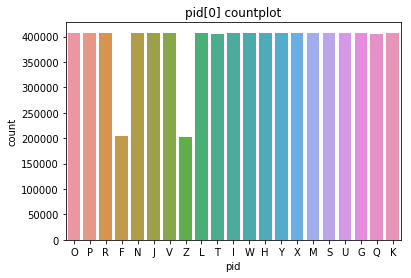

In [15]:
sns.countplot(train_df['pid'].apply(lambda x:x[0]))
plt.title('pid[0] countplot')
plt.show()
#거의 약 40만개로 비슷, F와 Z만 약 20만개

In [16]:
def print_nunique(df, col):
    print('#unique bcateid: ', df[col].nunique())
    
print_nunique(train_df, 'bcateid')
print_nunique(train_df, 'mcateid')
print_nunique(train_df, 'scateid')
print_nunique(train_df, 'dcateid')

#unique bcateid:  57
#unique mcateid:  552
#unique scateid:  3190
#unique dcateid:  404


In [17]:
def count_null(df):
    for i in df.columns:
        print(i, ' : ', sum(df[i].isnull()))

#null check
count_null(train_df)

pid  :  0
product  :  0
brand  :  3930121
maker  :  2196847
price  :  0
updttm  :  0
bcateid  :  0
mcateid  :  0
scateid  :  0
dcateid  :  0


In [18]:
def count_null(df):
    for i in df.columns:
        print(i, ' : ', df[i].isnull().count())

#null check
count_null(train_df)

pid  :  8134818
product  :  8134818
brand  :  8134818
maker  :  8134818
price  :  8134818
updttm  :  8134818
bcateid  :  8134818
mcateid  :  8134818
scateid  :  8134818
dcateid  :  8134818


In [19]:
def count_blank(df):
    for i in df.columns:
        print(i, ' : ', df[df[i]=='']['pid'].count())
        
#blank check
count_blank(train_df)

pid  :  0
product  :  0
brand  :  0
maker  :  0
price  :  0
updttm  :  0
bcateid  :  0
mcateid  :  0
scateid  :  0
dcateid  :  0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [20]:
def count_blank(df):
    cnt = 0
    for i in df.columns:
        for j in df[i]:
            if "NaN" in j:
                cnt += 1
        print(i, ' : ', cnt)    
        
#blank check
count_blank(train_df)

pid  :  0
product  :  11


TypeError: argument of type 'float' is not iterable

In [ ]:
def count_semi_null(df, col):
    cnt = 0
    for j in df[col]:
        if j=='-1' or j==-1:
            cnt += 1
    print(col, ' : ', cnt)
    
#-1 check
count_semi_null(train_df, 'price')
count_semi_null(train_df, 'scateid')
count_semi_null(train_df, 'dcateid')

price  :  5270821
scateid  :  1866120
dcateid  :  7376926


In [ ]:
train_df[train_df['pid'].apply(lambda x:x[0])=='O'].head(20)

,pid,product,brand,maker,price,updttm,bcateid,mcateid,scateid,dcateid
0,O4486751463,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),퍼즐라이프,상품상세설명 참조,16520,20180227091029,1,1,2,-1
13,O4109219298,[한일] 엘린(ELIN) 올파이브 통오중(5PLY)냄비5종(10PCS),,한일스테인레스,187800,20171123022655,16,19,21,-1
57,O4436052894,[기타] [라벨루쏘] [롱샴] [르 플리아쥬 백팩] 1699 089 556 [169...,기타,롱샴,-1,20180322192119,31,55,64,11
95,O4593740867,GT 삼성 광마우스 SMH-3100UB,중국,중국,26020,20180407092222,24,73,98,-1
127,O4149499960,"[보리보리] 후추통(이미용,생활) P0680 옥탄트 귀걸이(은침.케이스포함)","후추통(이미용,생활)","후추통(이미용,생활)",-1,20180419024415,20,60,113,-1
143,O3493375065,트랜스폼 거치대(블랙),,(주)티씨엠,-1,20180403130243,39,98,139,-1
148,O3405782544,크레이저커피 드릴 원두커피(500g),,크레이저커피,-1,20180424230126,41,102,144,-1
149,O3576039626,린나이[롯데백화점]참숯코팅 무수그릴 펄크리스탈상판 가스오븐레인지 RSF-BM82C,린나이,(주)린나이코리아,-1,20180429054749,42,104,146,-1
195,O4547267720,[커스텀에이블]커스텀에이블 플라워 프릴 슬릿넥 원피스_ C1803OP028A,커스텀에이블,㈜able.h,-1,20180426133432,9,51,181,-1
199,O3188404165,[속옷천국] [에뜨랑제][RU974]화려하고은은한 펄그라데이션 꽃무늬 노와이어 몰드...,속옷천국,에뜨랑제,-1,20180314132144,5,91,158,17


In [ ]:
train_df[train_df['pid'].apply(lambda x:x[0])=='O'].head(20)['bcateid'].unique()

array([ 1, 16, 31, 24, 20, 39, 41, 42,  9,  5, 38, 12, 17,  6, 14,  3, 18])

In [22]:
train_df['pid_pre'] = train_df['pid'].apply(lambda x:x[0])
train_df.head(20)

,pid,product,brand,maker,price,updttm,bcateid,mcateid,scateid,dcateid,pid_pre
0,O4486751463,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),퍼즐라이프,상품상세설명 참조,16520,20180227091029,1,1,2,-1,O
1,P3307178849,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...,바보사랑,MORY|해당없음,20370,20180429085019,3,3,4,-1,P
2,R4424255515,크리비아 기모 3부 속바지 GLG4314P,크리비아,NaN,-1,20180426102314,5,5,6,-1,R
3,F3334315393,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,잭앤질,㈜크리스패션,16280,20180422084512,7,7,8,-1,F
4,N731678492,코드프리혈당시험지50매/코드프리시험지/최장유효기간,NaN,기타,-1,20180424071623,10,9,11,-1,N
5,J4094617432,아트박스 POOM/낭만창고 idk385-시원한 맥주 캬하~,NaN,NaN,-1,20180426150317,11,10,12,-1,J
6,V4742097320,데버스 뉴 캠핑 BBQ 글러브 DVC E1209N 캠핑 등산,NaN,기타,-1,20180422222810,12,11,13,-1,V
7,Z4154445264,엘르스포츠 여성 비키니2PCS ETFLB06NVY,엘르스포츠,기타,-1,20180420064936,13,12,14,-1,Z
8,L2121928457,[패션플러스][GEOX][GEOX] 제옥스 GH-405 블랙펄 클러치백,제옥스,제옥스,30750,20180419090423,14,13,15,-1,L
9,J2944368118,[아트박스 POOM/꾸밈] iz099-우럭아왜우럭,꾸밈,꾸밈,25200,20180401085848,11,15,17,-1,J


In [32]:
# pid_pre_groupby = train_df.groupby('pid_pre').agg({
#     'pid': 'count',
#     'bcateid': 'nunique',
#     'mcateid': 'nunique',
#     'scateid': 'nunique',
#     'dcateid': 'nunique',
# })
# pid_pre_groupby

In [42]:
pid_pre_groupby = train_df.groupby('pid_pre')
pid_pre_O = pid_pre_groupby.get_group('O')
pid_pre_O.head(10)

,pid,product,brand,maker,price,updttm,bcateid,mcateid,scateid,dcateid,pid_pre
0,O4486751463,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),퍼즐라이프,상품상세설명 참조,16520,20180227091029,1,1,2,-1,O
13,O4109219298,[한일] 엘린(ELIN) 올파이브 통오중(5PLY)냄비5종(10PCS),NaN,한일스테인레스,187800,20171123022655,16,19,21,-1,O
57,O4436052894,[기타] [라벨루쏘] [롱샴] [르 플리아쥬 백팩] 1699 089 556 [169...,기타,롱샴,-1,20180322192119,31,55,64,11,O
95,O4593740867,GT 삼성 광마우스 SMH-3100UB,중국,중국,26020,20180407092222,24,73,98,-1,O
127,O4149499960,"[보리보리] 후추통(이미용,생활) P0680 옥탄트 귀걸이(은침.케이스포함)","후추통(이미용,생활)","후추통(이미용,생활)",-1,20180419024415,20,60,113,-1,O
143,O3493375065,트랜스폼 거치대(블랙),NaN,(주)티씨엠,-1,20180403130243,39,98,139,-1,O
148,O3405782544,크레이저커피 드릴 원두커피(500g),NaN,크레이저커피,-1,20180424230126,41,102,144,-1,O
149,O3576039626,린나이[롯데백화점]참숯코팅 무수그릴 펄크리스탈상판 가스오븐레인지 RSF-BM82C,린나이,(주)린나이코리아,-1,20180429054749,42,104,146,-1,O
195,O4547267720,[커스텀에이블]커스텀에이블 플라워 프릴 슬릿넥 원피스_ C1803OP028A,커스텀에이블,㈜able.h,-1,20180426133432,9,51,181,-1,O
199,O3188404165,[속옷천국] [에뜨랑제][RU974]화려하고은은한 펄그라데이션 꽃무늬 노와이어 몰드...,속옷천국,에뜨랑제,-1,20180314132144,5,91,158,17,O


In [41]:
pid_pre_O.describe()

,price,updttm,bcateid,mcateid,scateid,dcateid
count,4.062880e+05,4.062880e+05,406288.000000,406288.00000,406288.000000,406288.000000
mean,3.879296e+04,2.017954e+13,20.799782,156.95436,567.479746,6.208081
std,1.000266e+06,3.046032e+09,14.083511,135.92449,714.469472,34.349904
min,-1.000000e+00,2.015042e+13,1.000000,1.00000,-1.000000,-1.000000
25%,-1.000000e+00,2.018032e+13,9.000000,40.00000,18.000000,-1.000000
50%,-1.000000e+00,2.018041e+13,17.000000,131.00000,224.000000,-1.000000
75%,1.469000e+04,2.018042e+13,32.000000,234.00000,889.000000,-1.000000
max,5.154835e+08,2.018043e+13,57.000000,552.00000,3190.000000,401.000000


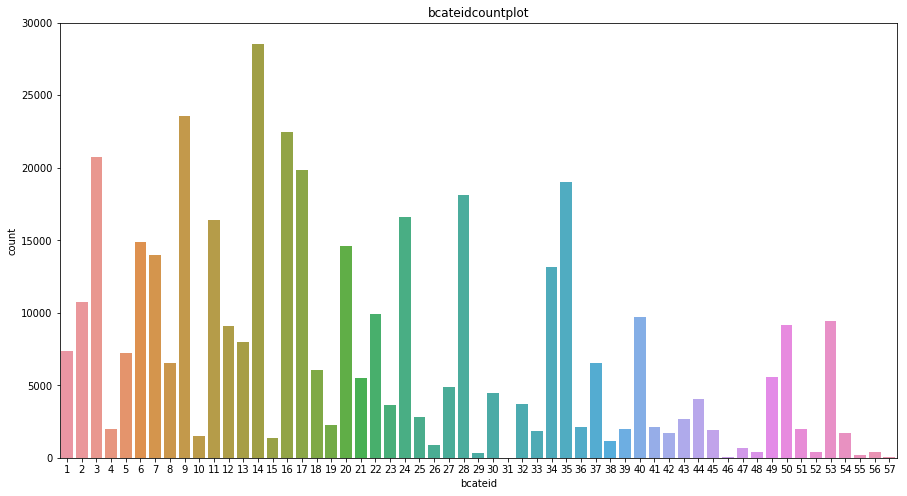

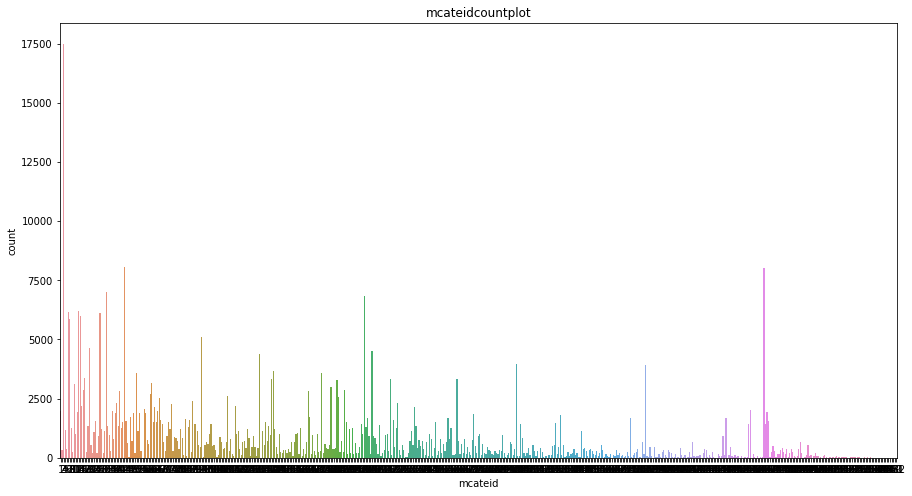

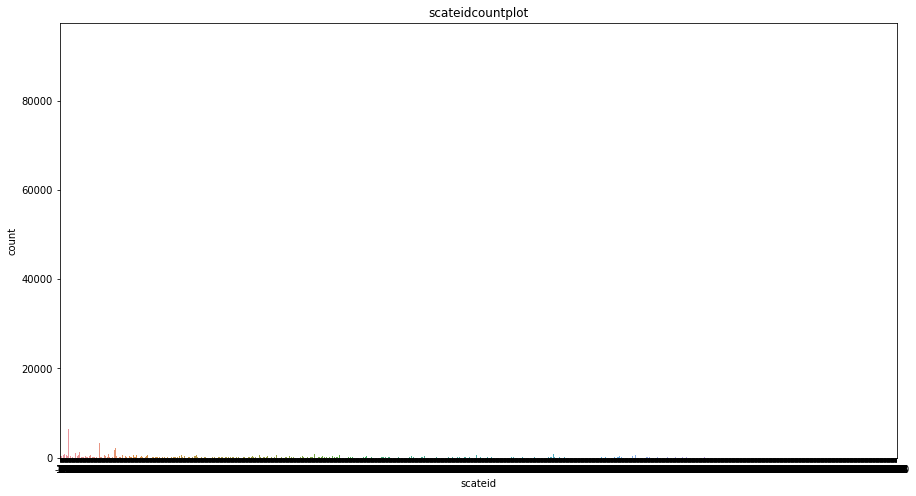

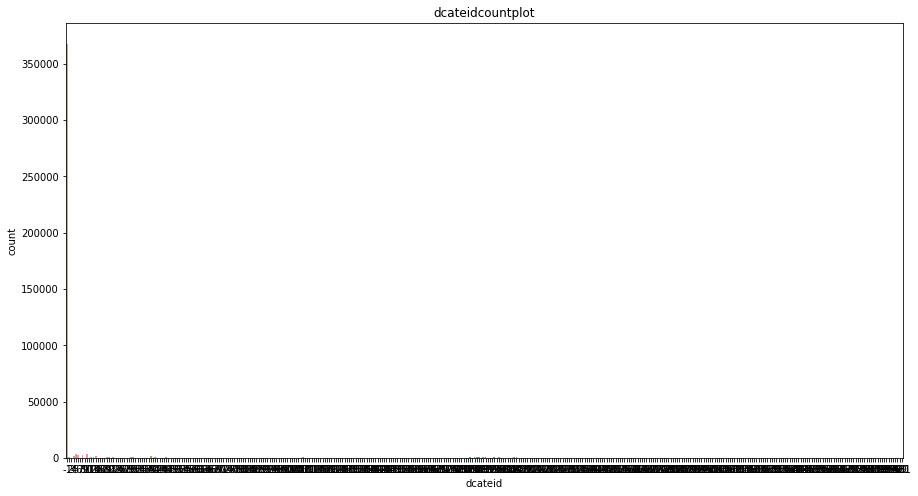

In [46]:
def print_countplot(col):
    plt.figure(figsize=(15,8))
    sns.countplot(pid_pre_O[col])
    plt.title(col+'countplot')
    plt.show()

cateid_list = ['bcateid', 'mcateid', 'scateid', 'dcateid']
for i in cateid_list:
    print_countplot(i)

#별로 의미가 없는듯
